# Inteligentne nożyce
## Przygotowanie środowiska

In [61]:
from pathlib import Path
import cv2, timeit, json, numpy as np
from src.pathfinder import Pathfinder
from src.utilities import eval_path
import matplotlib.pyplot as plt
from collections import Counter


In [62]:
data_dir = Path("./data")
configs_dir = data_dir / Path("./configs")
images_dir = data_dir / Path("./images")
paths_txt_dir = data_dir / Path("./paths_txt")
paths_img_dir = data_dir / Path("./paths_img")

times_file = data_dir / Path("./times.txt")
summary_file = data_dir / Path("./summary.txt")

data_dir.mkdir(exist_ok=True)
configs_dir.mkdir(exist_ok=True)
images_dir.mkdir(exist_ok=True)
paths_txt_dir.mkdir(exist_ok=True)
paths_img_dir.mkdir(exist_ok=True)

## Stworzenie zestawu konfiguracji

In [63]:
def create_config_json(json_name, laplace, direction, magnitude):
    jsondict = {
        "laplace_w": laplace,
        "direction_w": direction,
        "magnitude_w": magnitude,
        "laplace_kernels": [3, 5, 7],
        "gaussian_kernel": 5,
        "laplace_weights": [0.2, 0.3, 0.5],
        "maximum_cost": 255,
    }

    with open(json_name, 'w+') as f:
        json.dump(jsondict, f, indent=4)

In [92]:
limit_up = 5
limit_down = 0
step = 0.3

cfg_num = 0
for laplace in np.arange(limit_down, limit_up, step):
    for direction in np.arange(limit_down, limit_up, step):
        for magnitude in np.arange(limit_down, limit_up, step):
            create_config_json(configs_dir / f"cfg_{cfg_num:05}.json", laplace, direction, magnitude)
            cfg_num += 1
print(f"Created {cfg_num} configurations!")

Created 4913 configurations!


## Wczytanie danych

In [65]:
image = cv2.imread("./testimage3.png")
path_reference = cv2.imread("testimage3_path_reference.png")
selected_points = [(19, 41), (34, 29), (54, 50), (24,64), (19, 41)]

## Analiza dokładności stworzonych konfiguracji

In [66]:
times_str = "cfg_num;start_xy;end_xy;exec_time\n"
summary_str = "cfg_num;path_score;time_total\n"
all_scores = {}
min_configs = []
min_score = np.inf
for config_file in configs_dir.glob("*.json"):
    print(f"\r Processing configuration: {config_file}", end="")
    image_temp = image.copy()
    path_image = np.zeros_like(image)
    cfg_num = config_file.stem.split("_")[1]

    pathfinder = Pathfinder(image, config_file=config_file)

    path = []
    time_total = 0
    for i in range(len(selected_points)-1):
        start_xy = selected_points[i]
        end_xy = selected_points[i+1]
        t_start = timeit.default_timer()
        found_path = pathfinder.find_path(*start_xy, *end_xy)
        t_end = timeit.default_timer()
        exec_time = t_end - t_start
        times_str += f"{cfg_num};{start_xy};{end_xy};{exec_time}\n"
        time_total += exec_time
        path.extend(found_path)

    path_str = ""
    for x, y in path:
        image_temp[x, y, :] = (255, 255, 0)
        path_image[x, y, :] = (255, 255, 255)
        path_str += f"{x},{y}\n"
    pathfile = paths_txt_dir / f"path_{cfg_num}.txt"
    pathfile.write_text(path_str)

    cv2.imwrite(str(images_dir / f"img_{cfg_num}.png"), image_temp)
    cv2.imwrite(str(paths_img_dir / f"path_{cfg_num}.png"), path_image)
    
    path_score, hits, misses = eval_path(path_image, path_reference)
    all_scores[config_file] = path_score
    summary_str += f"{cfg_num};{path_score};{time_total}\n"

    if path_score == min_score:
        min_configs.append(config_file)
    elif path_score < min_score:
        min_score = path_score
        min_configs = [config_file]

times_file.write_text(times_str)
summary_file.write_text(summary_str)

2159

In [67]:
print(f"Best score:\n{min_score}")
print(f"Best configs:")
for best_cfg in min_configs:
    print(f"{best_cfg}")

Best score:
0.01025
Best configs:
data\configs\cfg_00045.json


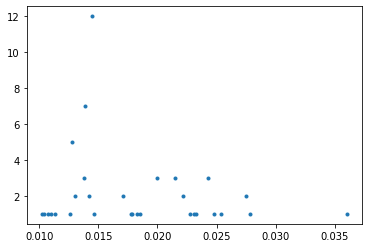

In [91]:
counted_scores = dict(Counter(list(all_scores.values())))
cscores_vals, cscores_count = zip(*counted_scores.items())
plt.plot(cscores_vals, cscores_count, '.')
plt.show()


## Testowanie wybranych konfiguracji

In [69]:
iterations = 100
scores = {}
times = {}

### Powtarzalność

In [70]:
for cfg in min_configs:
    scores[cfg] = []
    all_paths = []
    for j in range(iterations):
        print(f"\r{cfg} === {j}", end="")
        path_image = np.zeros_like(image)

        pathfinder = Pathfinder(image, config_file=cfg)

        path = []
        for i in range(len(selected_points)-1):
            start_xy = selected_points[i]
            end_xy = selected_points[i+1]
            found_path = pathfinder.find_path(*start_xy, *end_xy)
            path.extend(found_path)
        all_paths.append(path)
        for x, y in path:
            path_image[x, y, :] = (255, 255, 255)
        
        path_score, hits, misses = eval_path(path_image, path_reference)
        scores[cfg].append(path_score)
    print()
    if not all(all_paths[0] == l for l in all_paths[1:]):
        print(f"There are inconsistencies in path found for {cfg} file")

data\configs\cfg_00045.json === 9


### Czas wykonania

In [71]:
for cfg in min_configs:
    for j in range(iterations):
        print(f"\r{cfg} === {j}", end="")
        if not cfg in times:
            times[cfg] = {}

        path_image = np.zeros_like(image)

        pathfinder = Pathfinder(image, config_file=cfg)

        path = []
        for i in range(len(selected_points)-1):
            if not i in times[cfg]:
                times[cfg][i] = []
            start_xy = selected_points[i]
            end_xy = selected_points[i+1]
            t_start = timeit.default_timer()
            found_path = pathfinder.find_path(*start_xy, *end_xy)
            t_end = timeit.default_timer()
            exec_time = t_end - t_start
            times[cfg][i].append(exec_time)


data\configs\cfg_00045.json === 9

In [72]:
print("Indexes in times dictionary correlate to finding paths:")
for i in range(len(selected_points)-1):
    print(f"{i} = from {selected_points[i]} to {selected_points[i+1]}")

Indexes in times dictionary correlate to finding paths:
0 = from (19, 41) to (34, 29)
1 = from (34, 29) to (54, 50)
2 = from (54, 50) to (24, 64)
3 = from (24, 64) to (19, 41)


In [73]:
for k, v in times.items():
    print(f"=== {k} ===")
    for kk, vv in v.items():
        print(f"{kk}'s avg: {sum(vv)/iterations}")


=== data\configs\cfg_00045.json ===
0's avg: 0.06243913999996949
1's avg: 0.08012940999992679
2's avg: 0.04840346999994836
3's avg: 0.042392610000024436


## Wykresy